In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

画像を読み込む。

In [2]:
image_file = 'samples/1.png'
img = cv2.imread(image_file, 1)

読み込んだ画像を表示する。

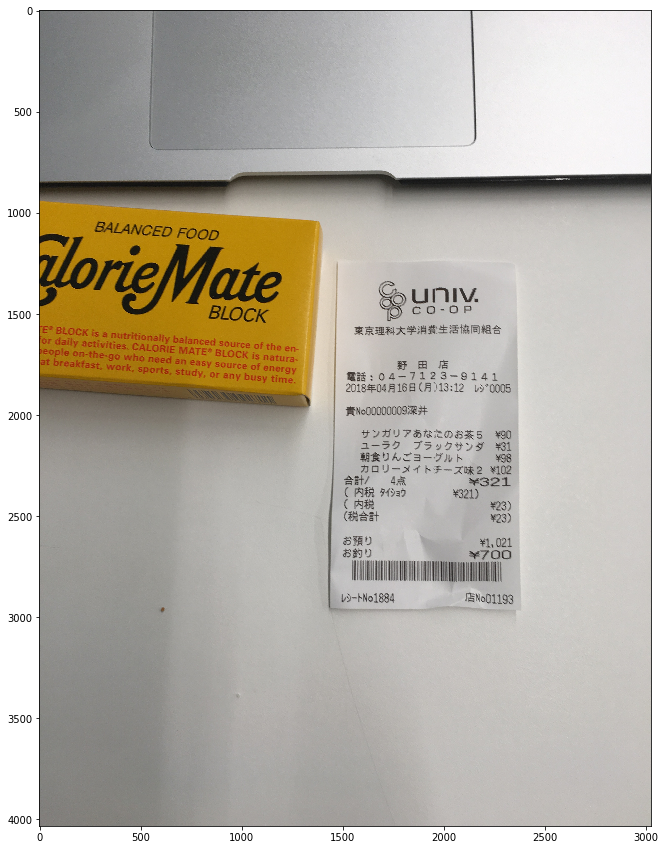

In [3]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## モルフォロジー変換

モルフォロジー変換による圧縮を行う。圧縮とは、カーネル領域にひとつでも0が含まれているならばそのカーネル領域内の画素をすべて0とする処理である。

これを行うことにより、0を強調する。

カーネルを定義する。

In [4]:
p = int(img.shape[:2][1]/100)
p = p if p % 2 == 1 else p + 1

kernel = np.ones((1, p*2), np.uint8)

カーネル領域の圧縮を行う。

In [5]:
erosion = cv2.erode(img, kernel, iterations=5)

モルフォロジー変換した画像を表示する。

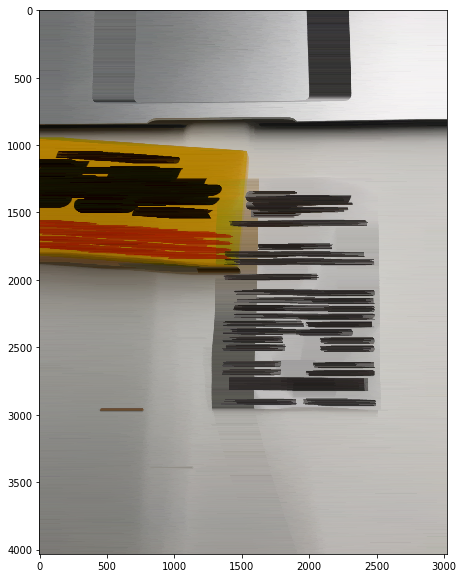

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(erosion, cv2.COLOR_BGR2RGB))

## ローパスフィルタによる平滑化

ローパスフィルタによる平滑化を行う。画像から高周波成分を取り除く。

これを行うことにより、ノイズを取り除きエッジを強調する。

カーネルと標準偏差を定義する。

In [7]:
kernel = (p*3+1, p*3+1)
#sigma = 0

平滑化を行う。

In [8]:
#blur = cv2.GaussianBlur(erosion, kernel, sigma)
#blur = cv2.bilateralFilter(erosion, 2*p, 10, 10)
blur = cv2.blur(erosion,kernel)

平滑化した画像を表示する。

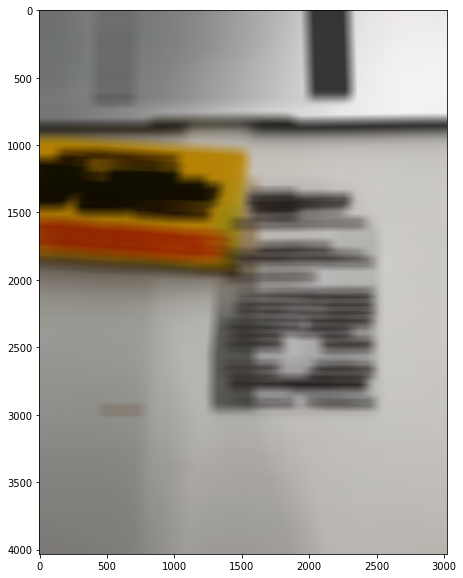

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

## ローカルしきい値処理

しきい値の処理にはグローバルしきい値処理とローカルしきい値処理が存在する。グローバルしきい値処理では画像全体にわたって同一のしきい値を用いる。一方でローカルしきい値処理では領域ごとに異なったしきい値を用いる。領域ごとにガウス分布に従う加重平均を取り、その値から定数を引くことでしきい値を補正する。

これを行うことにより、細かな線を強調しつつ画像を二値化する。

In [10]:
gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)

ローカルしきい値処理を行う。

In [11]:
th = cv2.adaptiveThreshold(gray, 255, 
                           cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \
                           cv2.THRESH_BINARY_INV, int(p), 2)

処理した画像を表示する。

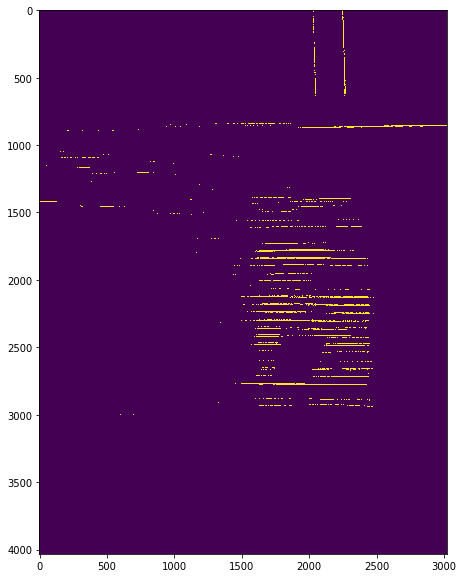

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(th)

## 画像切り取り関数

In [13]:
def crop_img(img, crop_width, crop_height, shift_x, shift_y):
    img_height, img_width = img.shape[:2]
    img_width += shift_x
    img_height +=  shift_y
    x1 = (img_width - crop_width) // 2
    y1 = (img_height - crop_height) // 2
    x2 = (img_width + crop_width) // 2
    y2 = (img_height + crop_height) // 2
    if y1 < 0:
        y1 = 0
    if x1 < 0:
        x1 = 0
    if y2 > img.shape[0]:
        y2 = img.shape[0]
    if x2 > img.shape[1]:
        x2 = img.shape[1]
        
    return img[y1:y2, x1:x2]

## 領域提案関数

In [14]:
from scipy import stats
from collections import Counter
import itertools

def proposal(bin_img, mode_th=3, rec_param=0.1, pre_param=1, max_param=1):
    max_side = min(bin_img.shape[:2]) * max_param
    increment = int(max_side/10)
    sides = np.arange(increment, max_side, increment)
    
    ratios = [1,1/3, 3, 1/6, 6]
    
    dx = int(bin_img.shape[:2][1]/4)
    dy = int(bin_img.shape[:2][0]/4)
    shift_x = [0, -dx, dx, -2*dx, 2*dx]
    shift_y = [0, -dy, dy, -2*dy, 2*dy]
    shifts = list(itertools.product(shift_x, shift_y))
    
    proposals = []
    
    for i, j in shifts:
        squres = []
        hights = []
        widths = []
        long_hights = []
        long_widths = []
        Fs = [squres, hights, widths, long_hights, long_widths]
        
        for (F, ratio) in zip(Fs, ratios):
            for side in sides:
                crop = crop_img(bin_img, int(side/ratio), int(side*ratio), i, j)
                all_w_pixels = cv2.countNonZero(bin_img) + 1
                sum_pixels = int(side/ratio) * int(side*ratio)
                w_pixels = cv2.countNonZero(crop) + 1
                b_pixels = sum_pixels - w_pixels

                rec = (w_pixels/all_w_pixels) * 100 * rec_param
                pre = (w_pixels/sum_pixels) * 100 * pre_param
                hmean = stats.hmean([rec, pre])
                F.append(hmean)
                
        F_ave = np.average(Fs, axis = 0)
        side = sides[np.argmax(F_ave)]
        mode = np.where(np.array(Fs)>mode_th)[0] \
        if len(np.where(np.array(Fs)>mode_th)[0]) != 0 else [1]
        c = Counter(mode)
        ratio = ratios[c.most_common(1)[0][0]]
        score = len(mode)
        proposals.append([score, side, ratio, i, j])
        
    proposals = sorted(proposals, key=lambda x: x[0], reverse=True)
            
    return proposals

## 領域合成関数

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

def syn_img(proposals, corr_th=0.9):
    ms =  MinMaxScaler()
    norm = ms.fit_transform(proposals[:][1:])
    syn =[proposals[0]]
    w = [2.]
    
    for i in range(1, len(proposals)-1):
        if proposals[i][0] > 1:
            corr = cosine_similarity([norm[0], norm[i]])[0][1]
            if corr > corr_th:
                syn.append(proposals[i])
                w.append(1.)
            
    return np.average(syn, weights=w, axis=0)

領域提案関数を実行し、結果を出力する。

In [16]:
first = proposal(th)

In [17]:
import pandas as pd

first_df = pd.DataFrame(first, columns = ['score', 'side', 'ratio', 'Δx', 'Δy'])
first_df

,score,side,ratio,Δx,Δy
0,14,1510,1.000000,756,0
1,13,1510,1.000000,756,1008
2,13,1510,1.000000,1512,0
3,12,1510,1.000000,756,-1008
4,11,1510,1.000000,1512,1008
5,9,1510,1.000000,1512,-1008
6,7,1510,1.000000,0,0
7,6,1812,3.000000,756,2016
8,5,1812,1.000000,0,-1008
9,5,1812,1.000000,0,1008


提案のうちもっともスコアが高い領域を表示する。

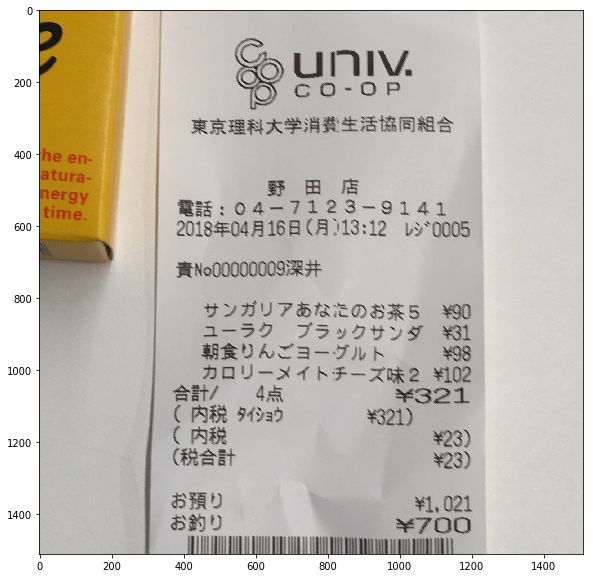

In [18]:
side = first[0][1]
ratio = first[0][2]
shift_x = first[0][3]
shift_y = first[0][4]

top = crop_img(img, int(side/ratio), int(side*ratio), int(shift_x), int(shift_y))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(top, cv2.COLOR_BGR2RGB))

領域合成関数を実行し、与えられた画像から結果を切り取る。

In [19]:
result = syn_img(first)

side = result[1]
ratio = result[2]
shift_x = result[3]
shift_y = result[4]

result1 = crop_img(img, int(side/ratio), int(side*ratio), int(shift_x), int(shift_y))

結果を表示する。

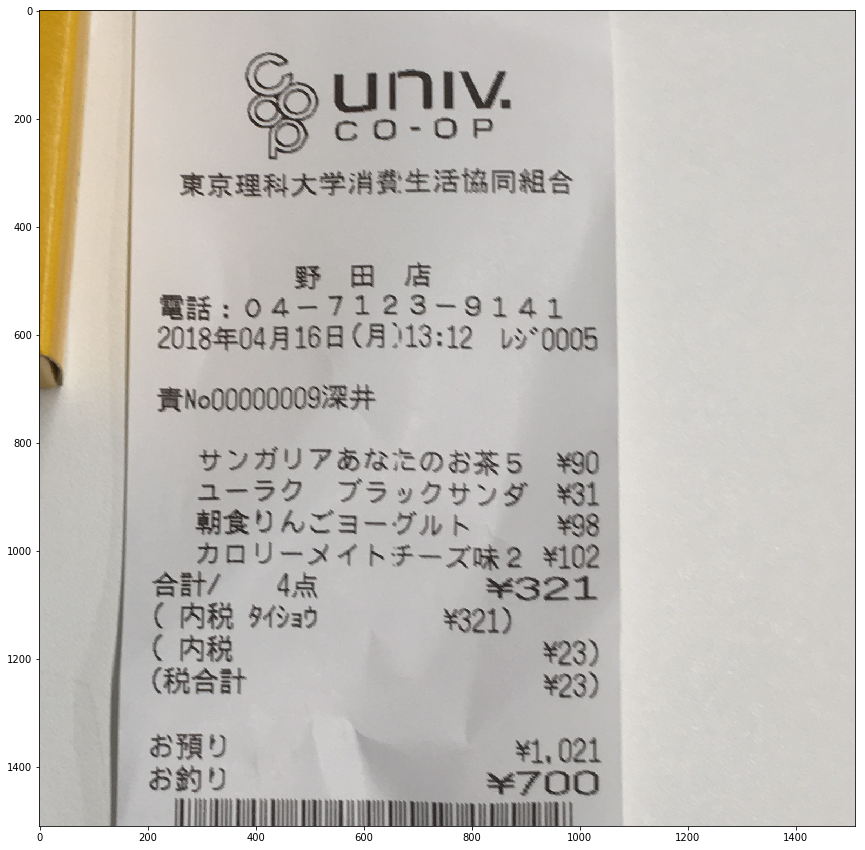

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))